In [1]:
import pints
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

In [2]:
import pints.toy as toy

class RescaledModel(pints.ForwardModel):
    def __init__(self):
        self.base_model = toy.LogisticModel()
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulate([r, k], times)
    
    def simulateS1(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulateS1([r, k], times)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2
    
model = toy.LogisticModel()
true_parameters = [0.015, 500]
start_parameters = [0.75, 1.0] # rescaled true parameters
times = np.linspace(0, 1000, 400)

In [3]:
runs = 50
n_iterations = 1000
factor = 1.1
x0 = np.array(start_parameters) * factor
sigma0 = np.array(start_parameters) * 5e-05

In [4]:
# Simulate time series
org_values = model.simulate(true_parameters, times)
range_values = max(org_values) - min(org_values)
noise = 0.05 * range_values
values = org_values + np.random.normal(0, noise, org_values.shape)

model = RescaledModel()
problem = pints.SingleOutputProblem(model, times, values)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

# Create (rescaled) bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.5, 0.8], [1.0, 1.2])
log_prior = pints.UniformLogPrior(bounds)
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Train emulator
input_parameters = log_prior.sample(2000)
likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)

likelihoods = np.array([0.7*l for l in likelihoods])
X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(problem, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=500, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
log_posterior_emu = pints.LogPosterior(emu, log_prior)

In [5]:
xs = []
diffs = []
orig_rule = []
first_rule = []
second_rule = []
step1 = [0] * n_iterations
step2 = [0] * n_iterations
alphas = []
orig = [0] * n_iterations
    
# Run MCMC methods 
for n in range(0, n_iterations):
    if n == 0:
        # Current point and proposed point
        current = x0
        current_log_pdf = log_posterior_emu(x0)
        true_current_log_pdf = log_posterior(x0)
        proposed = None

        # Acceptance rate and error monitoring
        error = 0
        accepted1 = 0
        accepted2 = 0
        orig_accepted = 0

        # Check initial position
        x0 = pints.vector(x0)

        # Get number of parameters
        n_parameters = len(x0)

        # Check initial standard deviation
        if sigma0 is None:
            # Get representative parameter value for each parameter
            sigma0 = np.abs(x0)
            sigma0[sigma0 == 0] = 1
            # Use to create diagonal matrix
            sigma0 = np.diag(0.01 * sigma0)
        else:
            sigma0 = np.array(sigma0)
            if np.product(sigma0.shape) == n_parameters:
                # Convert from 1d array
                sigma0 = sigma0.reshape((n_parameters,))
                sigma0 = np.diag(sigma0)
            else:
                # Check if 2d matrix of correct size
                sigma0 = sigma0.reshape((n_parameters, n_parameters))

    # Ask- Propose new point
    #if proposed is None:
    proposed = np.random.multivariate_normal(current, sigma0)

    # Tell    
    # Calculate logpdfs
    fx = log_posterior_emu(proposed)
    true_fx = log_posterior(proposed)
    error += np.abs((true_fx - fx) / true_fx)

    # Check if the proposed point can be accepted using the emulator
    if np.isfinite(fx):
        # Step 1 - Initial reject step:
        u1 = np.log(np.random.uniform(0, 1))
        alpha1 = min(0, (fx - current_log_pdf)[0][0]) # either alpha1 or alpha2 must be 0
        if alpha1 > u1:
            accepted1 += 1
            step1[n] = 1
            # Step 2 - Metropolis step:
            u2 = np.log(np.random.uniform(0, 1))
            alpha2 = min(0, (current_log_pdf - fx)[0][0])
            if ((true_fx + alpha2) - (true_current_log_pdf + alpha1)) > u2:
                accepted2 += 1 
                step2[n] = 1

    # Check if the proposed point can be accepted using standard MCMC
    if np.isfinite(fx):
        # Step 1 - Initial reject step:
        u = np.log(np.random.uniform(0, 1))
        alpha = true_fx - true_current_log_pdf
        if alpha > u:
            orig_accepted += 1
            orig[n] = 1

    # Clear proposal
    xs.append(proposed)
    proposed = None
    
    # Compute difference between emulator and true model
    diff = true_fx - fx
    diffs.append(diff[0][0])
    orig_rule.append(alpha)
    first_rule.append(alpha1)
    if step1[n] == 1:
        second_rule.append(((true_fx + alpha2) - (true_current_log_pdf + alpha1)))
        alphas.append(alpha2)
    else:
        second_rule.append(-200)
        alphas.append(0)


# Compute acceptance rates
mae = error[0][0] / n_iterations
acceptances = accepted2 / n_iterations
acceptances1 = accepted1 / n_iterations
acceptances2 = accepted2 / accepted1
orig_acceptances = orig_accepted / n_iterations


In [6]:
print("Overall:", acceptances)
print("1st-step:", acceptances1)
print("2nd-step:", acceptances2)
print("Original:", orig_acceptances)


Overall: 0.415
1st-step: 0.495
2nd-step: 0.8383838383838383
Original: 0.497


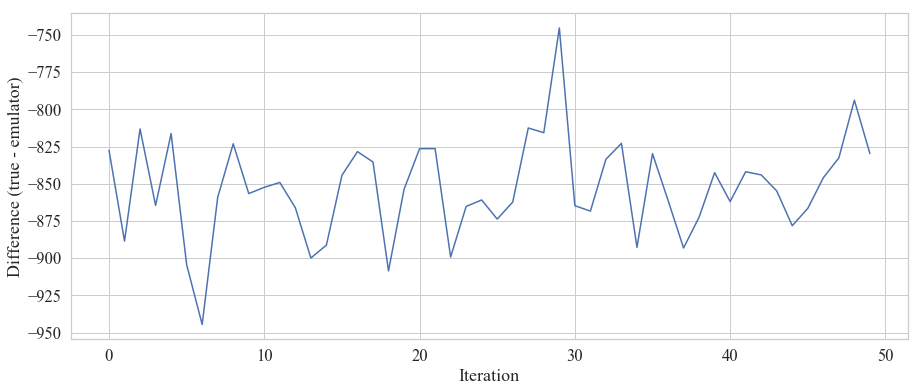

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='Times New Roman', 
        font_scale=1.5, color_codes=True, rc={"grid.linewidth": 1})

fig, ax = plt.subplots(figsize=(15,6))
plt.xlabel('Iteration')
plt.ylabel('Difference (true - emulator)')
ax.plot(diffs[:50])
plt.show()

#fig.savefig("figures/simulations/acceptances-"+str(factor)+".png", bbox_inches='tight', dpi=200)

In [29]:
step_sum = [s1 + s2 for (s1, s2) in zip(step1, step2)]
step_sum1 = [s - 1 if s>0 else s for s in step_sum]
sum([s == o for (s, o) in zip(step_sum1, orig)][:50])

48

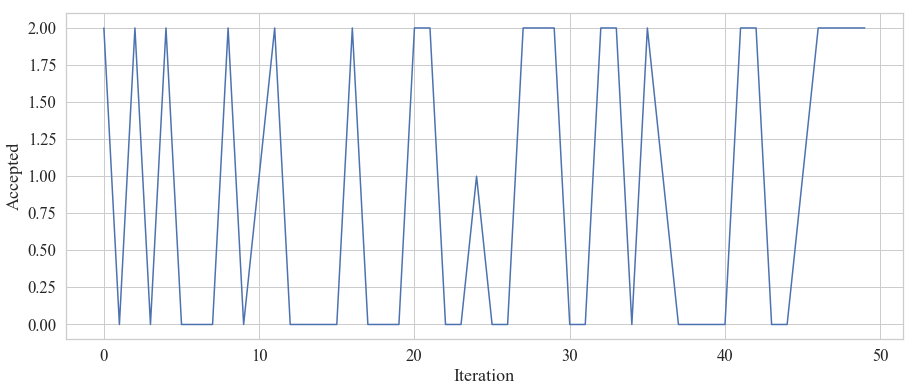

In [24]:
fig, ax = plt.subplots(figsize=(15,6))
plt.xlabel('Iteration')
plt.ylabel('Accepted')
ax.plot(step_sum[:50])
plt.show()

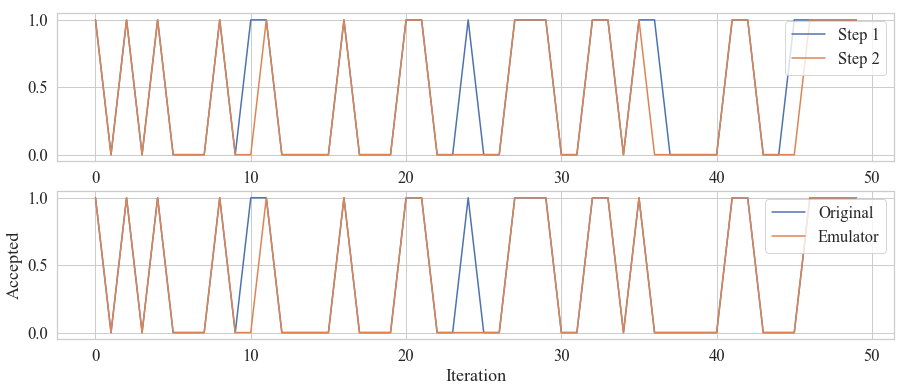

In [28]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(15,6))
plt.xlabel('Iteration')
plt.ylabel('Accepted')
ax1.plot(step1[:50], label='Step 1')
ax1.plot(step2[:50], label='Step 2')
ax1.legend()
ax2.plot(orig[:50], label='Original')
ax2.plot(step_sum1[:50], label='Emulator')
plt.legend()
plt.show()

#fig.savefig("figures/simulations/errors-"+str(factor)+".png", bbox_inches='tight', dpi=200)

In [11]:
step_sum = [s1 + s2 for (s1, s2) in zip(step1, step2)]
sum([s == o for (s, o) in zip(step_sum, orig)][:50])

28

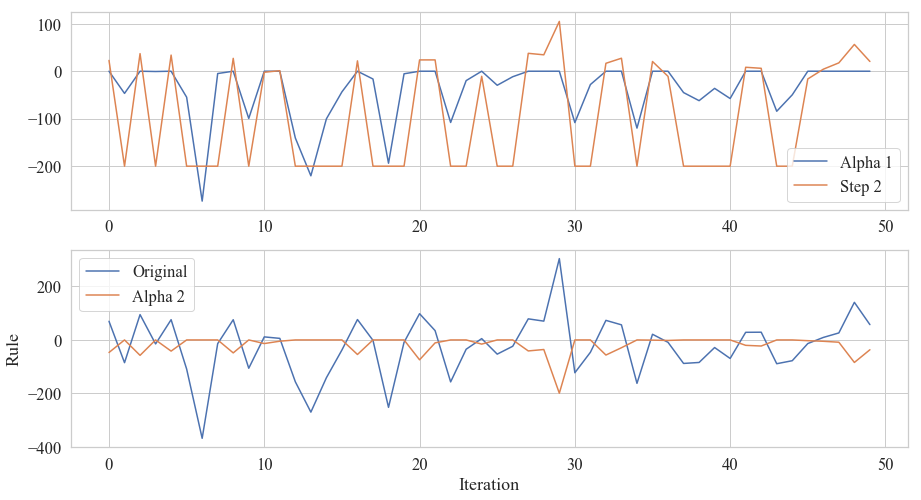

In [17]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(15,8))
plt.xlabel('Iteration')
plt.ylabel('Rule')
ax1.plot(first_rule[:50], label='Alpha 1')
ax1.plot(second_rule[:50], label='Step 2')
ax1.legend()
ax2.plot(orig_rule[:50], label='Original')
ax2.plot(alphas[:50], label='Alpha 2')
ax2.legend()
plt.show()

#fig.savefig("figures/simulations/errors-"+str(factor)+".png", bbox_inches='tight', dpi=200)

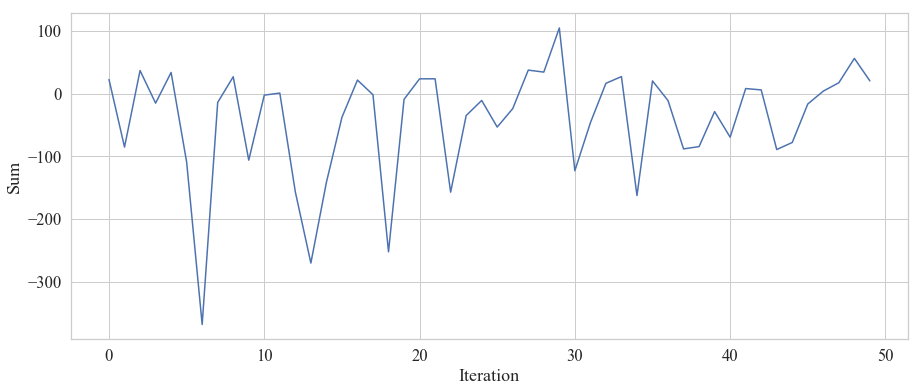

In [14]:
addition = [o + a for (o, a) in zip(orig_rule, alphas)]

fig, ax = plt.subplots(figsize=(15,6))
plt.xlabel('Iteration')
plt.ylabel('Sum')
ax.plot(addition[:50])
#ax.plot(second_rule[:50], label='Step 2')
plt.show()

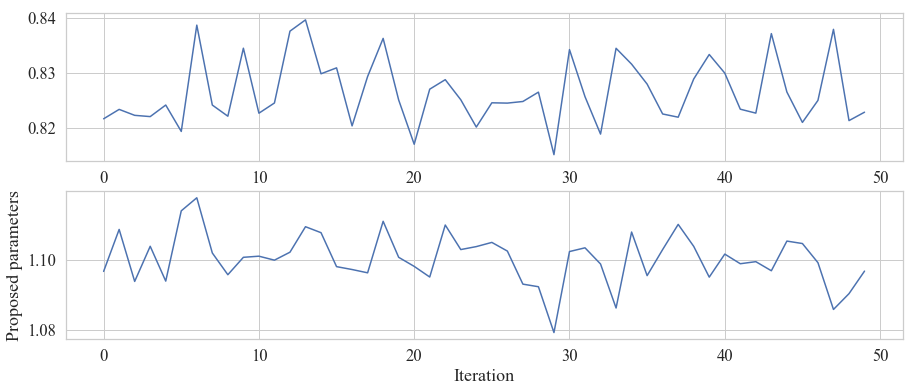

In [12]:
r = [x[0] for x in xs]
k = [x[1] for x in xs]
fig, (ax1, ax2) = plt.subplots(2, figsize=(15,6))
plt.xlabel('Iteration')
plt.ylabel('Proposed parameters')
ax1.plot(r[:50])
ax2.plot(k[:50])
plt.show()

#fig.savefig("figures/simulations/acceptances-"+str(factor)+".png", bbox_inches='tight', dpi=200)

In [37]:
delta = 0.01

x1 = x0 - [delta, 0.0]
x2 = x0 + [delta, 0.0]
gradient_emux = (emu(x2) - emu(x1)) / (2*delta)
print(gradient_emux)

y1 = x0 - [0.0, delta]
y2 = x0 + [0.0, delta]
gradient_emuy = (emu(y2) - emu(y1)) / (2*delta)
print(gradient_emuy)
print("\n")

gradient_x = (log_likelihood(x2) - log_likelihood(x1)) / (2*delta)
print(gradient_x)

gradient_y = (log_likelihood(y2) - log_likelihood(y1)) / (2*delta)
print(gradient_y)

[[-8741.596]]
[[-6785.016]]


-9959.588377545015
-11355.322302270473
